In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import os

class GraphMap:
    """
    Đại diện cho đồ thị vô hướng.
    """
    def __init__(self, n=0):
        self.n = n
        self.adj_list = {} 
        self.edges = [] 
        if n > 0:
            self.reset_graph(n)

    def reset_graph(self, n):
        """Khởi tạo lại đồ thị với n đỉnh."""
        self.n = n
        self.adj_list = {i: [] for i in range(n)}
        self.edges = []

    def add_edge(self, u, v):
        """
        Thêm cạnh vô hướng (u, v).
        Args:
            u (int): Đỉnh nguồn.
            v (int): Đỉnh đích.
        """
        if u != v and v not in self.adj_list[u]:
            self.adj_list[u].append(v)
            self.adj_list[v].append(u)
            self.edges.append((u, v))

    def generate_random_edges(self, probability=0.4):
        """
        Sinh cạnh ngẫu nhiên (chỉ dùng khi N < 25).
        Args:
            probability (float): Xác suất tồn tại cạnh giữa hai đỉnh.
            0 < probability < 1
        """
        self.reset_graph(self.n)
        for i in range(self.n):
            for j in range(i + 1, self.n):
                if random.random() < probability:
                    self.add_edge(i, j)

    def load_from_matrix(self, matrix):
        """
        Nạp đồ thị từ ma trận kề (List of Lists).
        Args:
            matrix (list of list of int): Ma trận kề NxN.
        """
        n = len(matrix)
        self.reset_graph(n)
        for r in range(n):
            for c in range(r + 1, n): # Chỉ duyệt tam giác trên ma trận để tránh trùng lặp cạnh
                if matrix[r][c] == 1:
                    self.add_edge(r, c)

    def load_from_file(self, filepath):
        """
        Đọc file input.txt.
        Format:
        Dòng 1: N
        Các dòng sau: Ma trận kề NxN (các số cách nhau bởi khoảng trắng)
        Args:
            filepath (str): Đường dẫn tới file input.txt.
        """
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Khong tim thay file: {filepath}")
            
        with open(filepath, 'r') as f:
            lines = f.readlines()
            
        # Đọc N
        try:
            n = int(lines[0].strip())
        except ValueError:
            raise ValueError("Dong dau tien phai la so nguyen N")
            
        # Đọc ma trận
        matrix = []
        # Bắt đầu đọc từ dòng thứ 2 (index 1)
        # Bỏ qua các dòng trống nếu có
        valid_lines = [line.strip() for line in lines[1:] if line.strip()]
        
        for i in range(n):
            if i >= len(valid_lines):
                break
            row_str = valid_lines[i]
            row = [int(x) for x in row_str.split()]
            if len(row) != n:
                raise ValueError(f"Dong ma tran thu {i+1} khong du {n} cot")
            matrix.append(row)
            
        if len(matrix) != n:
            raise ValueError(f"File khong du {n} dong ma tran")
            
        self.load_from_matrix(matrix)
        return n

In [11]:
class OptimalColoringSolver:
    """
    Thực thi thuật toán tô màu tối ưu trên đồ thị.
    Chiến lược: Ưu tiên tô màu các đỉnh có bậc cao nhất trước (High Degree First).
    """
    def __init__(self, graph_map):
        self.graph = graph_map
        self.result_colors = {} 

    def solve(self):
        """
        Chạy thuật toán tô màu.
        Returns: history (list of dicts) - Lịch sử các bước tô màu.
        """
        history = []
        self.result_colors = {}
        
        # --- BƯỚC 1: TÍNH BẬC CỦA CÁC ĐỈNH ---
        # Tạo danh sách (node_id, degree)
        nodes_degree = []
        for i in range(self.graph.n):
            degree = len(self.graph.adj_list[i])
            nodes_degree.append((i, degree))
            
        # --- BƯỚC 2: SẮP XẾP ĐỈNH THEO BẬC GIẢM DẦN ---
        # Đỉnh có nhiều kết nối nhất sẽ được xử lý trước để tối ưu màu
        nodes_degree.sort(key=lambda x: x[1], reverse=True)
        
        # Lấy ra danh sách các đỉnh đã sắp xếp
        sorted_nodes = [item[0] for item in nodes_degree]
        
        # In ra thứ tự ưu tiên (để debug/theo dõi)
        print(f"Thu tu uu tien to mau (bac giam dan): {sorted_nodes}")
        
        # --- BƯỚC 3: TIẾN HÀNH TÔ MÀU (GREEDY) ---
        for node in sorted_nodes:
            # 1. Tìm tập hợp màu của các hàng xóm đã được tô trước đó
            neighbor_colors = set()
            for neighbor in self.graph.adj_list[node]:
                if neighbor in self.result_colors:
                    neighbor_colors.add(self.result_colors[neighbor])
            
            # 2. Chọn màu có chỉ số nhỏ nhất KHÔNG trùng với hàng xóm
            # Màu được đánh số 0, 1, 2...
            color_id = 0
            while color_id in neighbor_colors:
                color_id += 1
            
            # 3. Gán màu cho đỉnh hiện tại
            self.result_colors[node] = color_id
            
            # 4. Lưu lại trạng thái vào lịch sử
            history.append(self.result_colors.copy())
            
        return history

=== CAU HINH TO MAU DO THI ===
1. Nhan nut [R]: Random (Ngau nhien - Chi danh cho N < 25)
2. Nhan nut [F]: File (Doc tu input.txt)


Da sinh do thi ngau nhien N=15
----------------------------------------
THONG TIN DO THI:
   - So dinh (N):   15
   - So canh (E):   38
   - Nguon du lieu: Random (Prob=0.3)
----------------------------------------
Dang chay thuat toan to mau do thi toi uu...
Thu tu uu tien to mau (bac giam dan): [6, 9, 12, 10, 1, 7, 8, 4, 11, 5, 0, 2, 13, 3, 14]

DINH   | MAU TO (ID)    
--------------------------------------------------
0      | 0              
1      | 0              
2      | 1              
3      | 0              
4      | 2              
5      | 2              
6      | 0              
7      | 3              
8      | 4              
9      | 1              
10     | 2              
11     | 3              
12     | 1              
13     | 1              
14     | 0              
-> TONG SO MAU SU DUNG: 5

=== TUY CHON MAU SAC HIEN THI ===
Thuat toan can su dung 5 mau.
Ban co muon tu chon mau khong? (Nhap ten mau tieng Anh hoac Hex)
Vi du nhap: red blue green yellow (Can it n

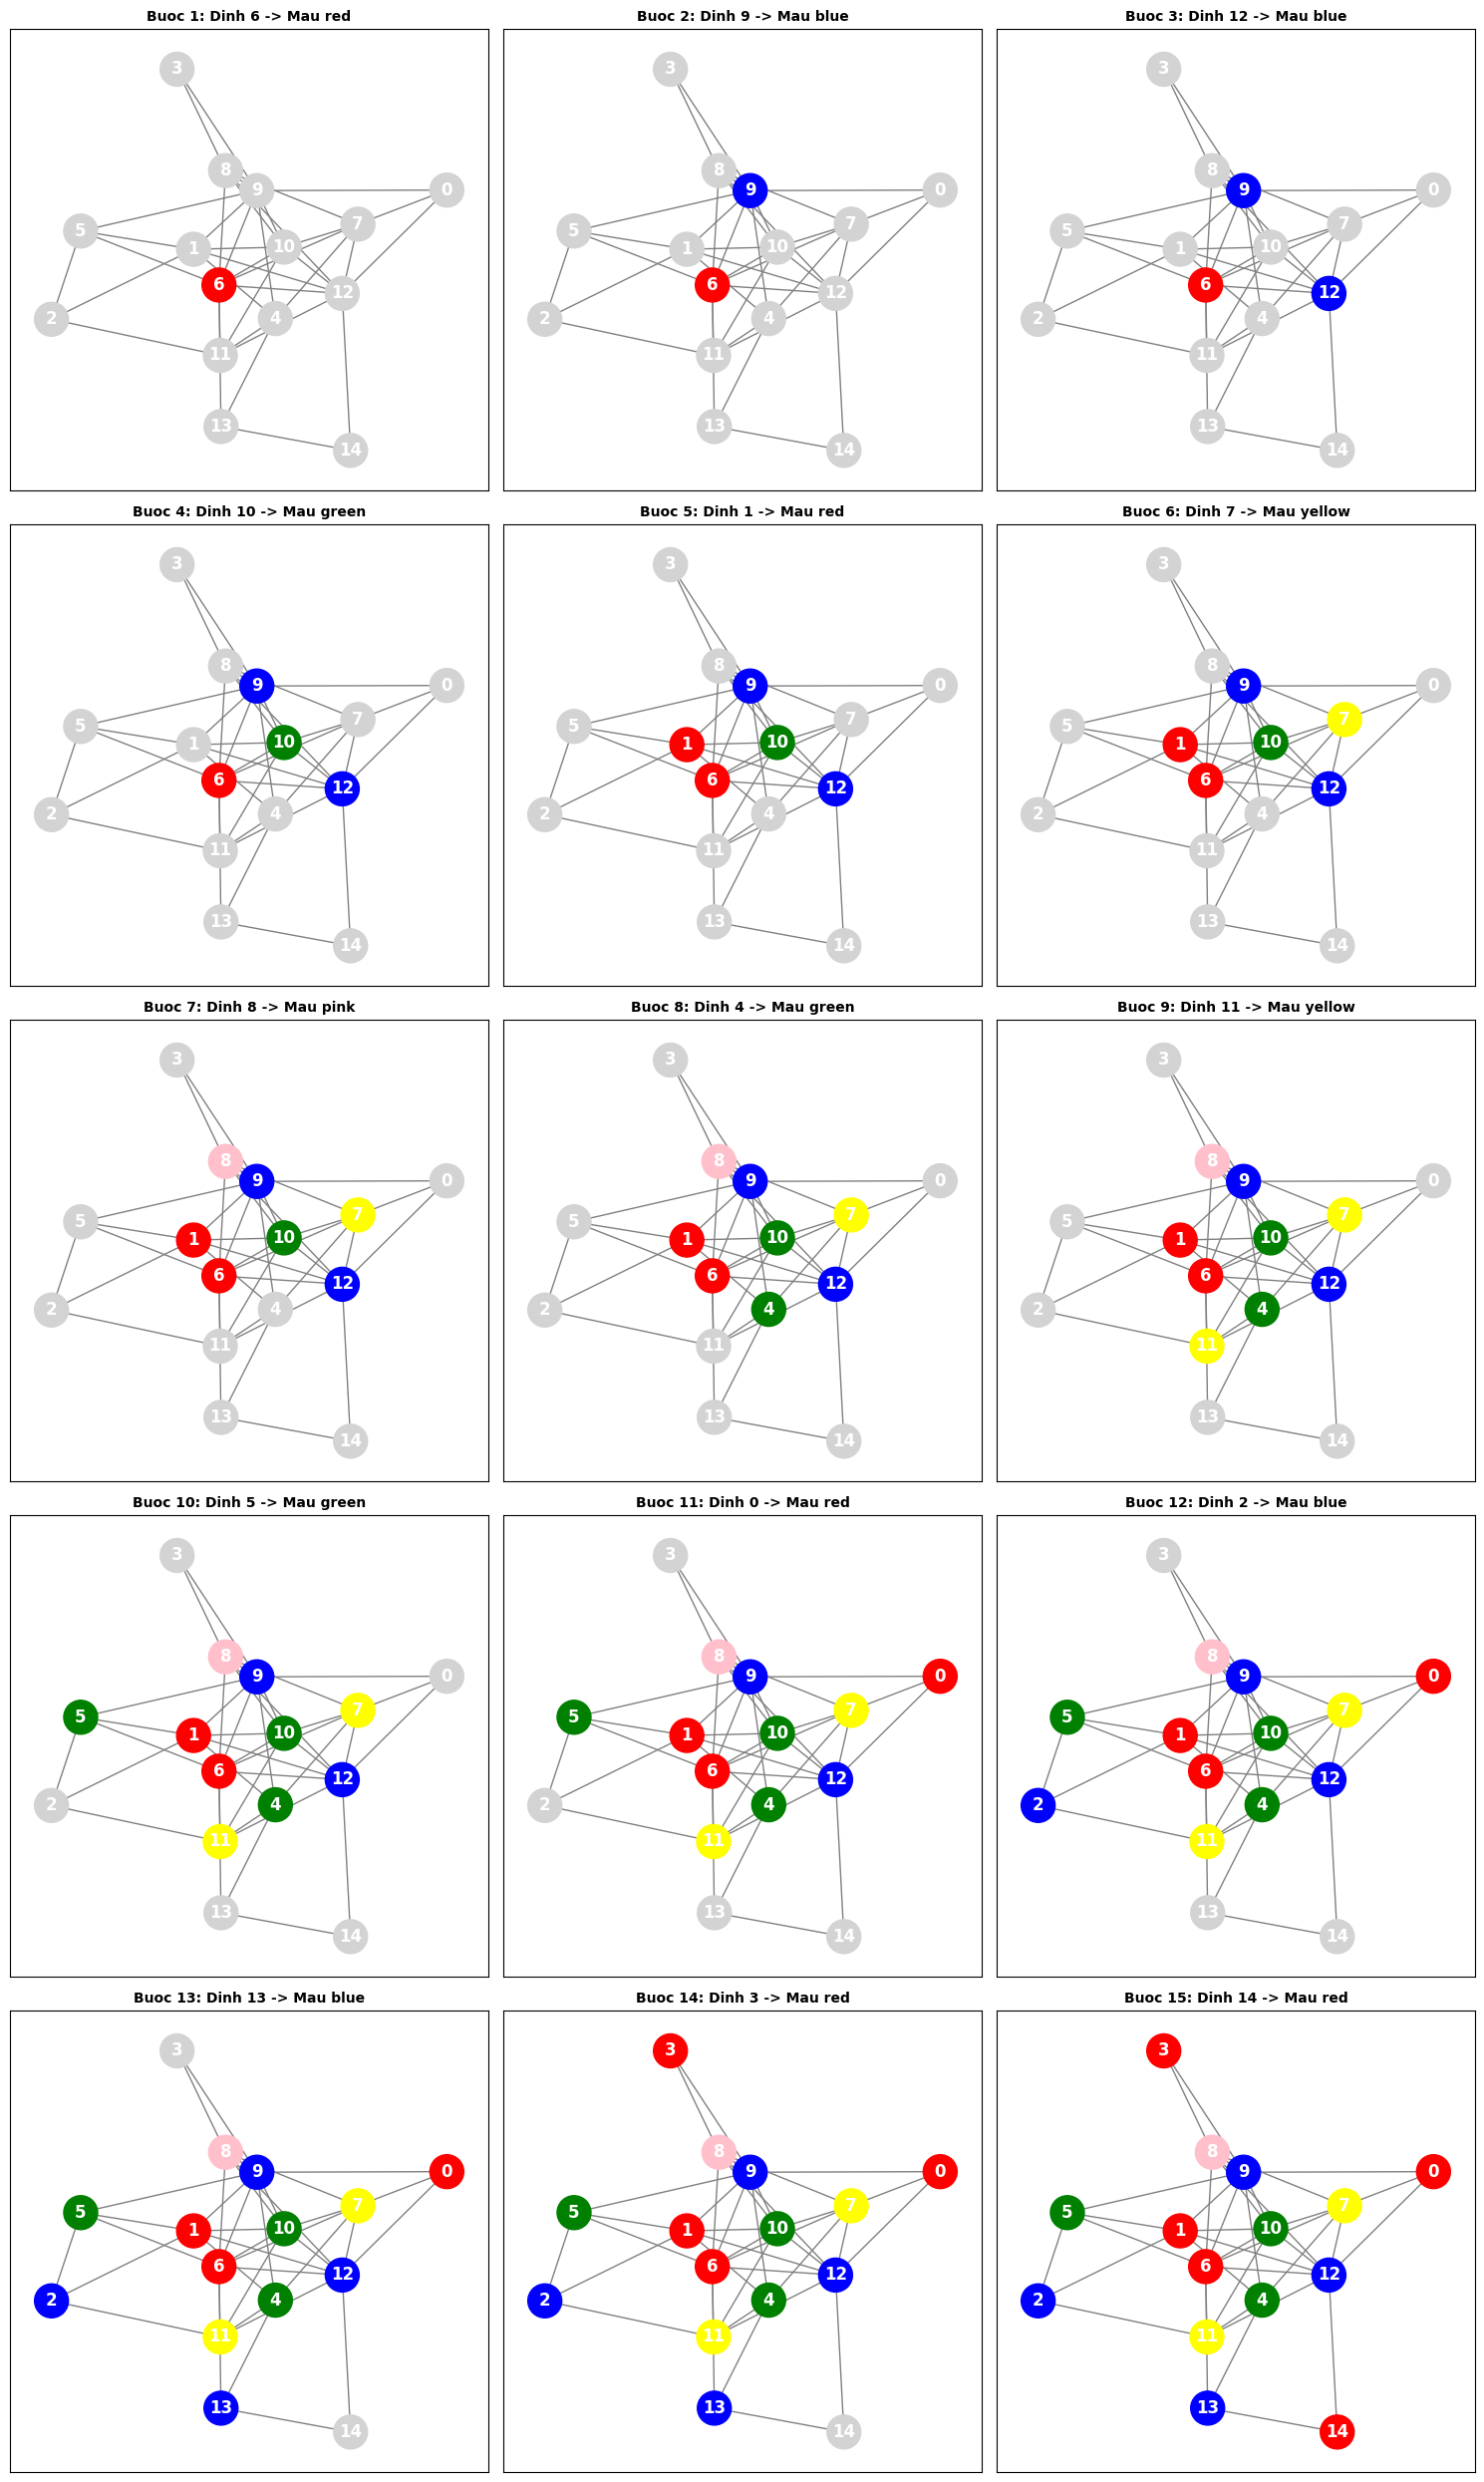

In [12]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import os

# --- HAM HIEN THI GRID ---
def visualize_coloring_history(graph_map, history, custom_palette=None, max_cols=3):
    '''
    Hiển thị quá trình tô màu đồ thị từng bước.
    Args:
        graph_map (GraphMap): Đồ thị cần tô màu.
        history (list of dicts): Lịch sử các bước tô màu.
        max_cols (int): Số cột tối đa trong lưới vẽ.
    '''
    n = graph_map.n # Số đỉnh
    total_steps = len(history) # Số bước trong lịch sử
    
    # Tạo đối tượng NetworkX để vẽ
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(graph_map.edges)
    
    # Layout cố định
    pos = nx.spring_layout(G, seed=42, k=0.5) 
    
    indices_to_draw = list(range(total_steps))  # Vẽ tất cả các bước
    num_plots = len(indices_to_draw)            # Số biểu đồ cần vẽ
    cols = max_cols                             # Số cột tối đa
    rows = math.ceil(num_plots / cols)          # Số hàng cần thiết
    
    fig_width = cols * 5
    fig_height = rows * 5
    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height)) 
    
    if num_plots > 1:
        axes_flat = axes.flatten() # Chuyển mảng 2D thành 1D 
    else: 
        axes_flat = [axes] 

    # --- XỬ LÝ BẢNG MÀU ---
    if custom_palette and len(custom_palette) > 0:
        # Nếu nhập màu
        color_palette = custom_palette
    else:
        # Mặc định 
        color_palette = plt.cm.tab20.colors 
    
    # --- VẼ TỪNG BƯỚC ---
    for idx, step_idx in enumerate(indices_to_draw):
        ax = axes_flat[idx]
        current_colors_dict = history[step_idx]
        
        node_color_list = []
        for node in G.nodes():
            if node in current_colors_dict:
                c_id = current_colors_dict[node]
                # Lấy màu từ palette (dùng phép chia lấy dư đề phòng không đủ màu)
                color = color_palette[c_id % len(color_palette)]
                node_color_list.append(color)
            else:
                node_color_list.append('lightgray') # Chưa tô
        
        nx.draw(G, pos, ax=ax, with_labels=True, 
                node_color=node_color_list, 
                edge_color='gray', node_size=600, font_color='white', font_weight='bold')
        
        # Tiêu đề
        last_node = list(current_colors_dict.keys())[-1]
        last_color_id = current_colors_dict[last_node]
        
        # Lấy tên màu (nếu là string) hoặc mã màu
        color_name = str(color_palette[last_color_id % len(color_palette)])
        # Rút gọn nếu là mã hex hoặc tuple rgb
        if len(color_name) > 10: color_name = f"ID_{last_color_id}"
            
        ax.set_title(f"Buoc {step_idx+1}: Dinh {last_node} -> Mau {color_name}", fontsize=10, fontweight='bold')
        ax.axis('on') 
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    for i in range(num_plots, len(axes_flat)):
        axes_flat[i].axis('off')
        
    plt.tight_layout()
    plt.show()

# --- HAM CHAY CHINH ---
def run_coloring_interactive():
    print("=== CAU HINH TO MAU DO THI ===")
    print("1. Nhan nut [R]: Random (Ngau nhien - Chi danh cho N < 25)")
    print("2. Nhan nut [F]: File (Doc tu input.txt)")
    
    mode = input("Chon che do (R/F): ").strip().upper()
    graph = GraphMap()
    
    try:
        if mode == 'F':
            filepath = "input.txt"
            if not os.path.exists(filepath):
                print(f"Khong tim thay file '{filepath}'.")
                return
            
            print(f"Dang doc file '{filepath}'...")
            n = graph.load_from_file(filepath)
            print(f"Doc thanh cong do thi N={n}")
            method_str = "File Input"
            
        else: # Mode Random
            val_n = input("Nhap so dinh N (< 25): ")
            n = 8 if not val_n.strip() else int(val_n)
            
            if n >= 25:
                print(f"N={n} qua lon cho che do Random. Vui long dung File hoac chon N < 25.")
                return 
            
            val_p = input("Nhap xac suat noi canh (Mac dinh 0.4): ")
            prob = 0.4 if not val_p.strip() else float(val_p)
            
            graph.reset_graph(n)
            graph.generate_random_edges(prob)
            print(f"Da sinh do thi ngau nhien N={n}")
            method_str = f"Random (Prob={prob})"

        # --- CHẠY GIẢI THUẬT ---
        print("-" * 40)
        print("THONG TIN DO THI:")
        print(f"   - So dinh (N):   {graph.n}")
        print(f"   - So canh (E):   {len(graph.edges)}")
        print(f"   - Nguon du lieu: {method_str}")
        print("-" * 40)
        
        print("Dang chay thuat toan to mau do thi toi uu...")
        solver = OptimalColoringSolver(graph)
        history = solver.solve()
        
        final_state = history[-1]
        num_colors = len(set(final_state.values()))
        
        # --- IN KẾT QUẢ DẠNG TEXT ---
        print("\n" + "="*50)
        print(f"{'DINH':<6} | {'MAU TO (ID)':<15}")
        print("-" * 50)
        for node in range(graph.n):
            color = final_state.get(node, "Chua to")
            print(f"{node:<6} | {color:<15}")
        print("="*50)
        print(f"-> TONG SO MAU SU DUNG: {num_colors}")
        
        # --- TÙY CHỌN MÀU SẮC ---
        print("\n=== TUY CHON MAU SAC HIEN THI ===")
        print(f"Thuat toan can su dung {num_colors} mau.")
        print("Ban co muon tu chon mau khong? (Nhap ten mau tieng Anh hoac Hex)")
        print(f"Vi du nhap: red blue green yellow (Can it nhat {num_colors} mau)")
        print("Hoac nhan ENTER de dung mau mac dinh.")
        
        user_colors_str = input("Nhap danh sach mau: ").strip()
        custom_palette = None
        
        if user_colors_str:
            custom_palette = user_colors_str.split()
            # Kiểm tra nếu nhập thiếu màu
            if len(custom_palette) < num_colors:
                print(f"[CANH BAO] Ban chi nhap {len(custom_palette)} mau, trong khi can {num_colors} mau.")
                print("Cac mau se duoc lap lai.")
        
        print("\nDang ve chi tiet tung buoc xu ly...")
        visualize_coloring_history(graph, history, custom_palette=custom_palette, max_cols=3)

    except Exception as e:
        print(f"[LOI CHUONG TRINH] {str(e)}")

# Gọi hàm chạy
run_coloring_interactive()